# About
This notebook shall evaluate the effect of the odds based on historical NCAA wins & losses on the final prediction
***

# Preface
## Imports

In [16]:
import os
os.chdir("/home/jovyan/work")

from IPython.core.display import HTML
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import text

from src.plotting import plot_odds
from src.utils import calc_odds, evaluate_log_loss, get_connection

## Config

In [17]:
%matplotlib inline
sns.set()
HTML("""
<style>
.output_png{
text-align:center;
}
</style>
""")

***
# Get the NCAA wins & losses

In [18]:
df_ncaa_results_wins_losses = pd.read_sql(
    sql=text("""
SELECT
ncaa.season as team_id_a,
ncaa.w_team_id,
wins_a.wins as wins_a,
losses_a.losses as losses_a,
ncaa.l_team_id as team_id_b,
wins_b.wins as wins_b,
losses_b.losses as losses_b
FROM t_original_ncaa_tourney_compact_results ncaa

-- join info about winning team
JOIN t_derived_ncaa_wins_per_team wins_a
    ON ncaa.w_team_id = wins_a.team_id
    
JOIN t_derived_ncaa_losses_per_team losses_a
    ON ncaa.w_team_id = losses_a.team_id
    
-- join info about losing team
JOIN t_derived_ncaa_wins_per_team wins_b
    ON ncaa.l_team_id = wins_b.team_id
    
JOIN t_derived_ncaa_losses_per_team losses_b
    ON ncaa.l_team_id = losses_b.team_id
    """),
    con=get_connection()
)
df_ncaa_results_wins_losses.head()

,team_id_a,w_team_id,wins_a,losses_a,team_id_b,wins_b,losses_b
0,1985,1116,30,18,1234,16,17
1,1985,1120,12,7,1345,28,24
2,1985,1207,33,21,1250,1,5
3,1985,1229,2,4,1425,9,12
4,1985,1242,80,30,1325,3,5


# Calculate the odds
For details see [0.1-jgoerner-winning-odds-per-game.ipynb](./0.1-jgoerner-winnig-odds-per-game.ipynb#Calculate-the-game-odds-for-A).

In [19]:
df_ncaa_w_l_odds = calc_odds(df_ncaa_results_wins_losses, 100, 100)

# Get an overall view on the team A odds

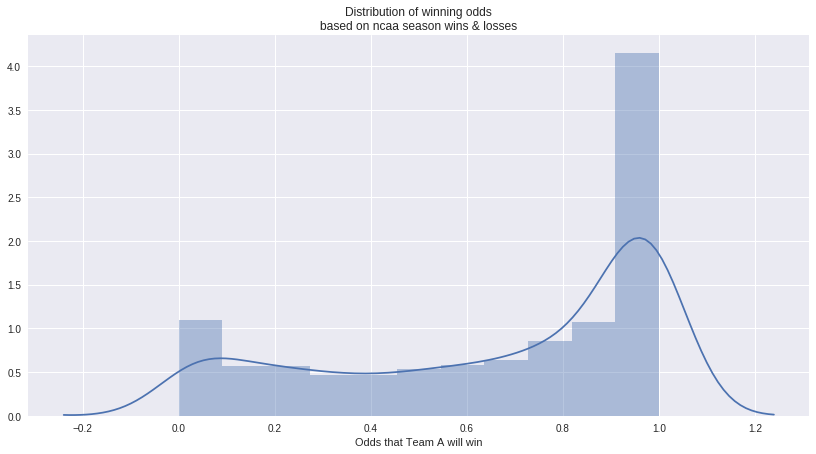

In [23]:
plt.rcParams["figure.figsize"] = (14, 7)
sns.distplot(df_ncaa_w_l_odds["odds_a"])
plt.title("Distribution of winning odds\nbased on ncaa season wins & losses")
plt.xlabel("Odds that Team A will win");
#plt.savefig("./figures/03_jgoerner_influence_historical_ncaa_odds_odd_distribution.png");

# Investigate the worst predictions
The worst predictions are those who's odds are 0.0 (or close). The log-loss function will penalize these (theoretically) with infinite loss. The following 

In [33]:
# get 6 worst predictions
df_ncaa_w_l_odds.sort_values("odds_a")[:6]

,team_id_a,w_team_id,wins_a,losses_a,team_id_b,wins_b,losses_b,odds_a
1393,2010,1140,7,18,1196,45,18,0.0000
615,1996,1343,2,11,1417,46,24,0.0001
890,2001,1429,1,10,1326,32,18,0.0001
467,1993,1143,9,14,1181,91,27,0.0002
401,1992,1190,1,9,1112,54,30,0.0003
1526,2012,1250,1,5,1181,91,27,0.0003


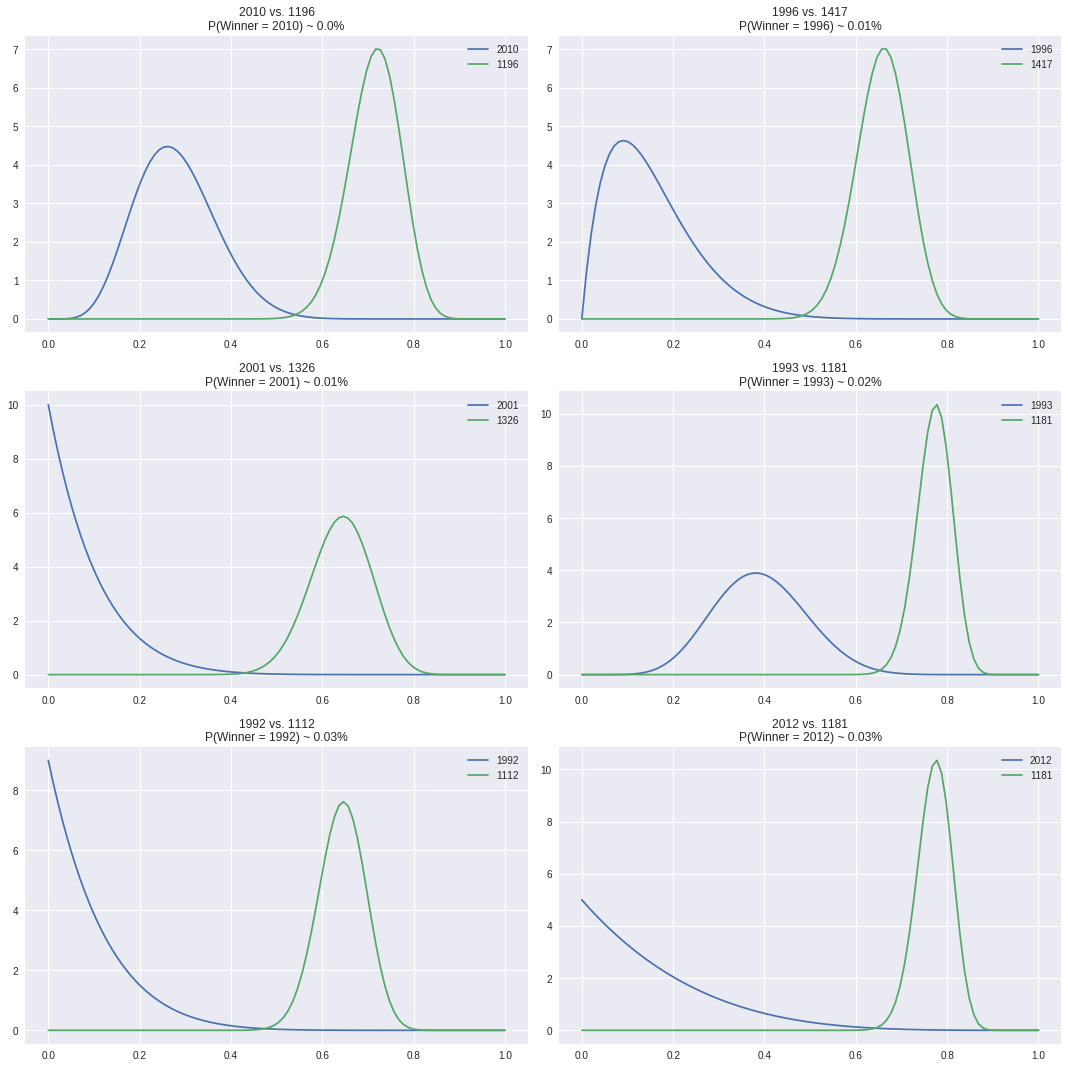

In [32]:
# plot the 6 worst predictions
plt.rcParams["figure.figsize"] = (15, 15)
fig, ax = plt.subplots(3, 2)
plt.sca(ax[0, 0])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[0,:])
plt.sca(ax[0, 1])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[1,:])
plt.sca(ax[1, 0])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[2,:])
plt.sca(ax[1, 1])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[3,:])
plt.sca(ax[2, 0])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[4,:])
plt.sca(ax[2, 1])
plot_odds(df_ncaa_w_l_odds.sort_values("odds_a").iloc[5,:])
plt.tight_layout();
#plt.savefig("./figures/01_jgoerner_why_simple_odds_fail_worst_predictions.png");

The odds based on historical NCAA data seem to underestimate the winning teams chances (opposed to overestimate the lossing teams chances as seen for the [odds based on regular season wins & losses](./0.2-jgoerner-why-simple-odds-fail.ipynb#Investigate-the-worst-predictions)).

# Outlook
As a next step the odds based on regular season wins & losses and the odds based on historical ncaa wins & losses shall be blended to produce a more stable estimate.